# Itertools benchmarks

## Imports and configuration

In [1]:
import time
import random
import timeit
import statistics
import itertools
import functools

import matplotlib.pyplot as plt
import pandas as pd

from memory_profiler import memory_usage
from timeout_decorator import timeout, TimeoutError

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

%load_ext autoreload
%autoreload 2

## Loading modules

### Placeholders

In [3]:
# Placeholders

class placeholder:
    @staticmethod
    def product(*iterables, repeat=1):
        return iter([1]) #itertools.product(*iterables, repeat=1)

    @staticmethod
    def permutations(iterable, r=None):
        return iter([1]) # itertools.permutations(iterable, r)

    @staticmethod
    def combinations(iterable, r):
        return iter([1]) # itertools.combinations(iterable, r)

class stdlib(placeholder):
    ...

class carlos(placeholder):
    @staticmethod
    def combinations(iterable, r):
        a = ["hello"] * 1000
        return iter([a]) # itertools.combinations(iterable, r)

class daniel(placeholder):
    @staticmethod
    def combinations(iterable, r):
        a = ["hello"] * 100000
        return iter([a]) # itertools.combinations(iterable, r)


In [4]:
import mitertools as daniel
import mitertools_rec as daniel_rec
import itertools as stdlib
import carlos
import carlos_rec

In [5]:
all_modules = stdlib, carlos, daniel, carlos_rec, daniel_rec

## Helper functions

In [6]:
def benchmark(bench):
    @functools.wraps(bench)
    def benchmark_wrapper(function):
        @timeout(5)
        def wrapped():
            return bench(function)
        return wrapped
    return benchmark_wrapper

In [7]:
def time_benchmarks(benchmarks, modules, function, runs):
    times = []
    for benchmark in benchmarks:
        print(f"Running benchmark [{benchmark.__doc__}]")
        benchmark_times = []
        for module in modules:
            print(f"-- Running benchmarks for {module.__name__} ", end="")
            func_times = [0]
            try:
                for _ in range(runs):
                    l = lambda: timeit.timeit(benchmark(getattr(module, function)), number=10)
                    func_times.append(l())
                    print(".", end="")
                print()
            except TimeoutError:
                print("TIMEOUT!")
                func_times = [0]
            except Exception as err:
                print(err)
            benchmark_times.append(statistics.median(func_times))
        times.append([benchmark.__doc__] + [t/max(benchmark_times) for t in benchmark_times])
    return times

In [8]:
# def memory_benchmarks(benchmarks, modules, function):
#     print("\nRunning memory benchmarks...")
#     memory = []
#     for benchmark in benchmarks:
#         print(f"Running benchmark [{benchmark.__doc__}]")
#         benchmark_mem = []
#         for module in modules:
#             print(f"-- Running benchmarks for {module.__name__} ", end="")
#             # func_mem = memory_usage(benchmark(getattr(module, function)))
#             def f():
#                 for _ in range(25):
#                     benchmark(getattr(module, function))()
#                     print(".", end="")
#                 print()
#             # func_mem = memory_usage(f)
#             f()
#             func_mem = [0]
#             # print(func_mem)
#             benchmark_mem.append(max(func_mem))
#             # print()
#         mem_diff_kib = [(m - min(benchmark_mem)) * 1024 for m in benchmark_mem]
#         print(benchmark_mem)
#         print(mem_diff_kib)
#         memory.append([benchmark.__doc__] + mem_diff_kib)
#     return memory

In [9]:
def plot(times, memory, modules, function):
    fig, axs = plt.subplots(1, 1)

    axs_time = axs

    module_names = [m.__name__ for m in modules]
    columns = ["Benchmark"] + module_names
    df = pd.DataFrame(list(reversed(times)), columns=columns)
    df.plot(x="Benchmark", y=module_names, kind="barh", ax=axs_time)
    axs_time.set_title(f"{function.capitalize()} (time)", size=20)
    axs_time.set_xlabel("time")
    axs_time.set_ylabel("")
    axs_time.grid()

    # df = pd.DataFrame(list(reversed(memory)), columns=columns)
    # df.plot(x="Benchmark", y=module_names, kind="barh", ax=axs[1])
    # axs[1].set_title(f"{function.capitalize()} (memory)", size=20)
    # axs[1].set_xlabel("difference in max memory usage (KiB)")
    # axs[1].set_ylabel("")
    # axs[1].set_xlim(left=0)
    # axs[1].grid()

    plt.show()

# Combinations

In [36]:
@benchmark
def combinations1(combinations):
    """3 elements, length 2"""
    _ = list(combinations("abc", 2))

@benchmark
def combinations2(combinations):
    """100 elements, length 3"""
    # _ = list(combinations(range(100), 3))
    _ = list(combinations("a" * 100, 3))
    
@benchmark
def combinations3(combinations):
    """first of 10000 elements, length 5"""
    _ = next(combinations(range(10000), 5))

In [40]:
runs = 2

benchmarks = [
    # combinations1,
    combinations2,
    # combinations3,
]

modules = all_modules

In [41]:
"asd"[1:2]

's'

In [42]:
times = time_benchmarks(benchmarks, modules, "combinations", runs)

Running benchmark [100 elements, length 3]
-- Running benchmarks for itertools ..
-- Running benchmarks for carlos .

KeyboardInterrupt: 

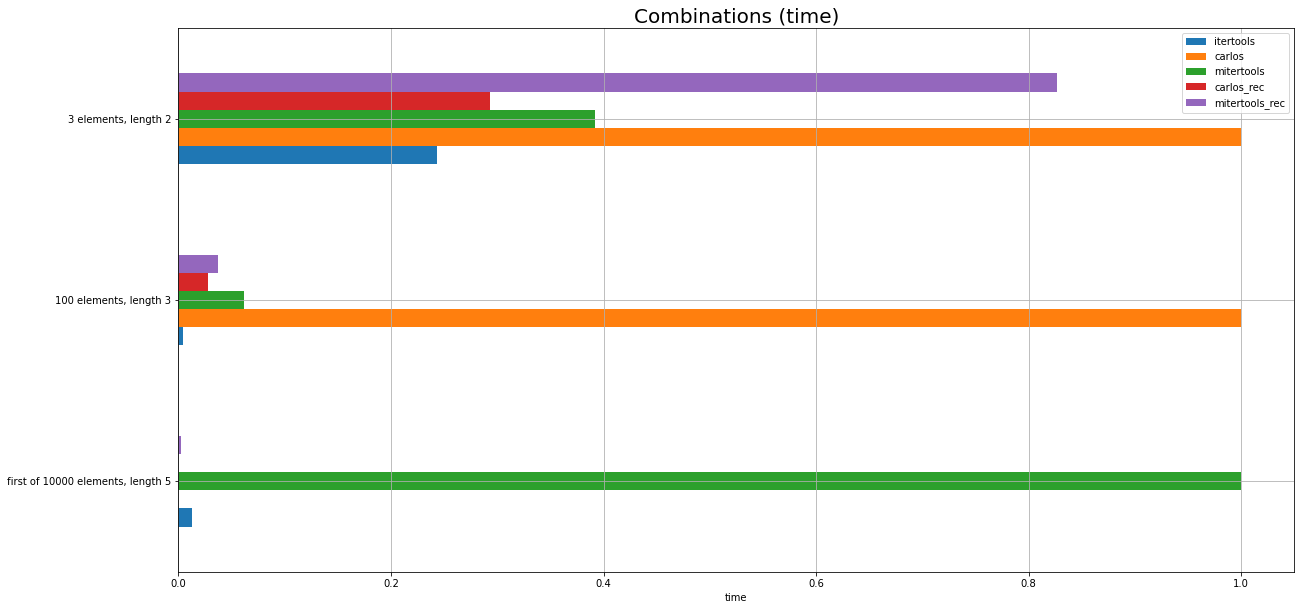

In [13]:
plot(times, [], modules, "combinations")

# Permutations

In [14]:
@benchmark
def permutations1(permutations):
    """3 elements, length 2"""
    _ = list(permutations("abc", 2))

@benchmark
def permutations2(permutations):
    """100 elements, length 3"""
    _ = list(permutations(range(100), 3))

@benchmark
def permutations3(permutations):
    """first of 10000 elements, length 5"""
    _ = next(permutations(range(10000), 5))

In [15]:
runs = 10

benchmarks = [
    permutations1,
    permutations2,
    permutations3,
]

modules = all_modules

In [16]:
times = time_benchmarks(benchmarks, modules, "permutations", runs)

Running benchmark [3 elements, length 2]
-- Running benchmarks for itertools ..........
-- Running benchmarks for carlos ..........
-- Running benchmarks for mitertools ..........
-- Running benchmarks for carlos_rec ..........
-- Running benchmarks for mitertools_rec ..........
Running benchmark [100 elements, length 3]
-- Running benchmarks for itertools ..........
-- Running benchmarks for carlos ..........
-- Running benchmarks for mitertools ..........
-- Running benchmarks for carlos_rec unsupported operand type(s) for +: 'range' and 'range'
-- Running benchmarks for mitertools_rec ..........
Running benchmark [first of 10000 elements, length 5]
-- Running benchmarks for itertools ..........
-- Running benchmarks for carlos TIMEOUT!
-- Running benchmarks for mitertools ..........
-- Running benchmarks for carlos_rec unsupported operand type(s) for +: 'range' and 'range'
-- Running benchmarks for mitertools_rec ..........


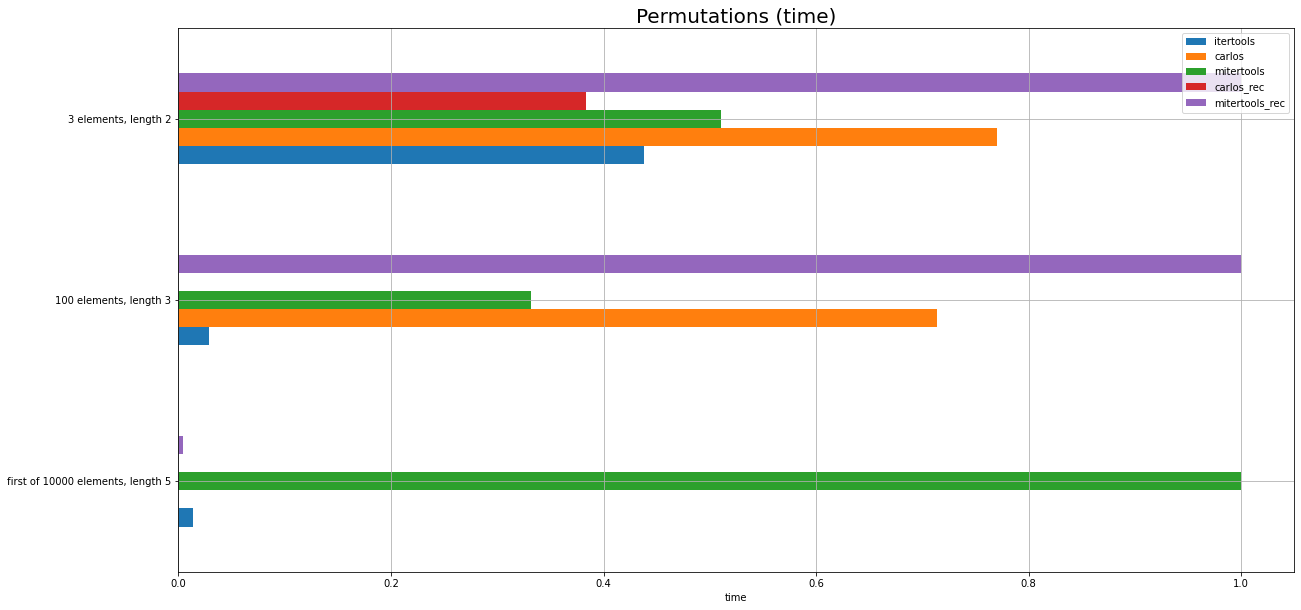

In [17]:
plot(times, [], modules, "permutations")

# Product

In [18]:
@benchmark
def product1(product):
    """product of 2 iterables"""
    _ = list(product([1, 2], "ab"))

@benchmark
def product2(product):
    """product of 4 iterables"""
    _ = list(product([1, 2], ["a", "b"], [True, False], [None, None, None]))

@benchmark
def product3(product):
    """2 iterables with repeat=4"""
    _ = list(product("ab", "cd", repeat=4))

@benchmark
def product4(product):
    """product of 2 big iterables"""
    _ = list(product(range(10000), range(1000)))

@benchmark
def product5(product):
    """First 100 elements of very big iterables"""
    for _ in range(100):
        next(product(range(1000000000), range(1000000000)))

@benchmark
def product6(product):
    """3 elements, length 2"""
    _ = list(product("abc", repeat=2))

@benchmark
def product7(product):
    """100 elements, length 3"""
    _ = list(product(range(100), repeat=3))

@benchmark
def product8(product):
    """first of 10000 elements, length 5"""
    _ = next(product(range(10000), repeat=5))



In [19]:
runs = 10

benchmarks = [
    # product1,
    # product2,
    # product3,
    # product4,
    # product5,
    product6,
    product7,
    product8,
]

modules = all_modules

In [20]:
times = time_benchmarks(benchmarks, modules, "product", runs)

Running benchmark [3 elements, length 2]
-- Running benchmarks for itertools ..........
-- Running benchmarks for carlos ..........
-- Running benchmarks for mitertools ..........
-- Running benchmarks for carlos_rec ..........
-- Running benchmarks for mitertools_rec ..........
Running benchmark [100 elements, length 3]
-- Running benchmarks for itertools ..........
-- Running benchmarks for carlos ..........
-- Running benchmarks for mitertools ..........
-- Running benchmarks for carlos_rec ..........
-- Running benchmarks for mitertools_rec ..........
Running benchmark [first of 10000 elements, length 5]
-- Running benchmarks for itertools ..........
-- Running benchmarks for carlos ..........
-- Running benchmarks for mitertools ..........
-- Running benchmarks for carlos_rec TIMEOUT!
-- Running benchmarks for mitertools_rec ..........


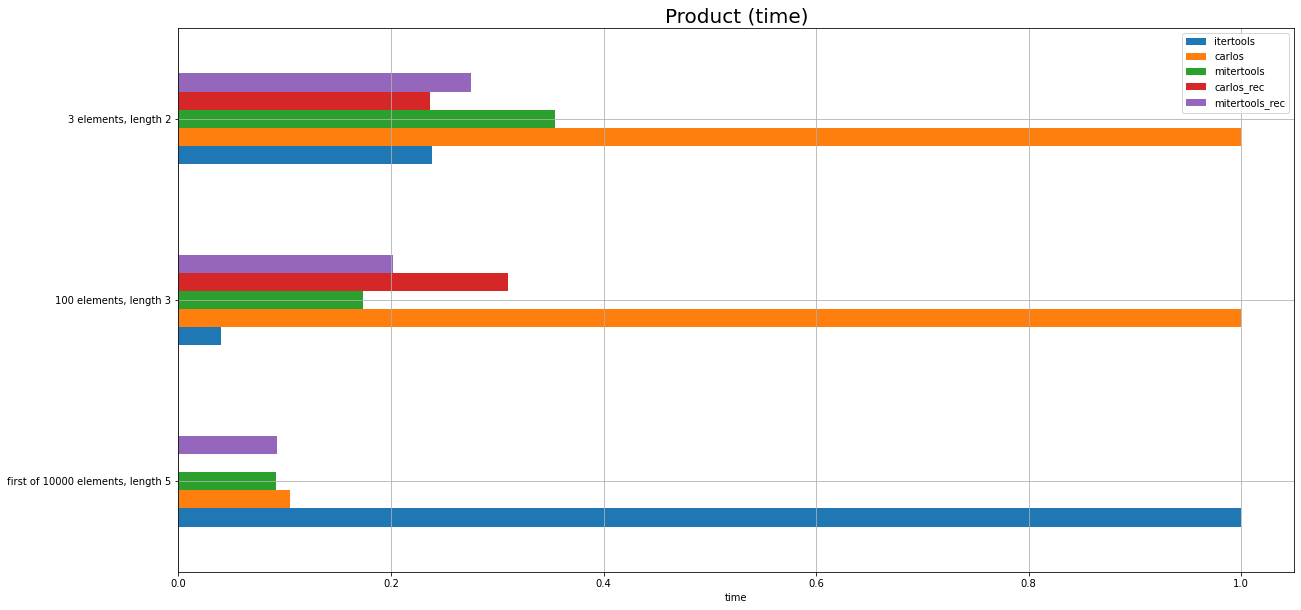

In [21]:
plot(times, [], modules, "product")

In [45]:
%timeit carlos.product("abc", repeat=2)

318 ns ± 6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [46]:
%timeit carlos.product123123("abc", repeat=2)

321 ns ± 12 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [57]:
%%prun -T prun0
for _ in range(1000000):
    carlos.product123123("abc", repeat=2)

 
*** Profile printout saved to text file 'prun0'. 


         1000003 function calls in 0.520 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.423    0.423    0.520    0.520 <string>:1(<module>)
  1000000    0.097    0.000    0.097    0.000 carlos.py:18(product123123)
        1    0.000    0.000    0.520    0.520 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}